## Imports

In [1]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Dense, Input, Concatenate, Lambda, regularizers, LeakyReLU, Softmax, Dropout, \
                         BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,8.27)})

Using TensorFlow backend.


## Loading Data

### Training Data

In [2]:
# loading and processing data
df = pd.read_csv("train_.csv")
df["StateRepresentation"] = df["StateRepresentation"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["MovesEncoded"] = df["MovesEncoded"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["hashed"] = df["StateRepresentation"].apply(lambda s: s.tostring())
df = df.sort_values('Value', ascending=False).drop_duplicates('hashed').sort_index()

# preparing data for deep learing
max_val = 16
x_train = df.StateRepresentation.values
x_train = np.array([x / max_val for x in x_train])

y_train = df.Value.values
y_train = np.array([np.array([val], dtype=float) for val in y_train])

KeyboardInterrupt: 

### Testing Data

In [2]:
# loading and processing data
df = pd.read_csv("test.csv")
df["StateRepresentation"] = df["StateRepresentation"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["MovesEncoded"] = df["Moves"].apply(lambda x: np.fromstring(x[1:-1], sep=" "))
df["hashed"] = df["StateRepresentation"].apply(lambda s: s.tostring())
df = df.sort_values('Value', ascending=False).drop_duplicates('hashed').sort_index()

# preparing data for deep learing
max_val = 16
x_test = df.StateRepresentation.values
x_test = np.array([x / max_val for x in x_test])

y_test = df.Value.values
y_test = np.array([np.array([val], dtype=float) for val in y_test])

In [3]:
x_test.shape

(10119, 24)

## Building the Model 

In [4]:
# params
width = 4
height = 6

shared_weights = [32, 16]
connected_layers = [64, 64, 32]

learning_rate = 0.002
batch_size = 124
epochs = 50

#directory = "Experiments/ValueFunction_03"

In [5]:
def build_model():
    inputArray = Input(shape=(24,))

    layer = inputArray

    shared_dense = Dense(shared_weights[0], activation='relu')
    layerArray = []

    for t in range(width):
        out = Lambda(lambda x: x[:, t*height:(t+1)*height])(layer)
        layerArray.append(shared_dense(out))

    layer = layerArray

    for neurons in shared_weights[1:]:
        shared_dense = Dense(neurons, activation='relu')
        layerArray = []
        for t in range(width):
            layerArray.append(shared_dense(layer[t]))
        layer = layerArray

    merged_vector = Concatenate(axis=-1)(layer)

    layer = merged_vector
    for neurons in connected_layers:
        layer = Dense(neurons, activation='relu')(layer)
        #layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True)(layer)
    output_layer = Dense(1, activation='linear')(layer)
    model = Model(input=inputArray, output=output_layer)

    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mse', metrics=['mae'])
    return model

In [6]:
tensorboard_cb = TensorBoard(log_dir=dir, histogram_freq=0,
                             write_graph=True, write_images=False)

checkpoint_cb = ModelCheckpoint(filepath=directory + "/model.hdf5", verbose=False)

early_stopping_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)

NameError: name 'directory' is not defined

## Training the Model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [17]:
model.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=epochs,
               shuffle=True,
               callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],
               validation_split=0.2,
               verbose=1)

NameError: name 'x_train' is not defined

# Loading a Model

In [7]:
model = build_model()
try:
    model.load_weights(filepath="TensorBoardFiles/KVN_4_6_SW_32_16_FC_64_64_32_0.005_128/model.hdf5")
    print("Loading existing model.")
except OSError:
    print("No existing model found.")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Loading existing model.


In [13]:
x_test[0,:]
testing = np.array([x_test[0,:]])

In [21]:
testing1 = np.array([x_test[0,:]])
start = time.time()
for _ in range(100000):
    model.predict(testing1)
end = time.time()
print(end-start)

33.12484908103943


In [22]:
testing2 = x_test[0:100,:]
start = time.time()
for _ in range(1000):
    model.predict(testing2)
end = time.time()
print(end-start)

1.2849371433258057


In [15]:
import time

## First Evaluation

In [8]:
model.evaluate(x_test, y_test)

10119/10119 [==============================] - 0s 25us/step


[0.24649945190830752, 0.3467371701393124]

In [42]:
y_pred = [x[0] for x in model.predict(x_test)]

In [43]:
comparison_df = pd.DataFrame(y_test)
comparison_df["pred"] = y_pred
comparison_df.comlumns = ["Y_true", "Y_pred"]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
comparison_df = comparison_df.rename(index=str, columns={0: "Y_true", "pred": "Y_pred"})

In [45]:
comparison_df["resid"] = comparison_df["Y_true"] - comparison_df["Y_pred"]
comparison_df["resid_abs"] = comparison_df["resid"].abs()

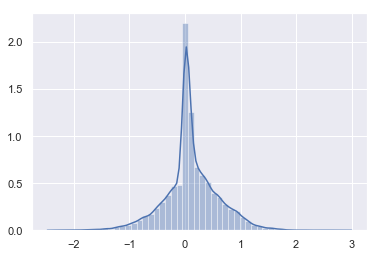

In [46]:
sns.distplot(comparison_df.resid.values);

## Numerical Analysis of Residuals

In [47]:
np.quantile(comparison_df.resid, 0.95)

0.9497614860534671

In [48]:
np.quantile(comparison_df.resid, 0.05)

-0.7106986045837402

In [49]:
comparison_df.resid.describe()

count    10119.000000
mean         0.109488
std          0.484288
min         -2.313617
25%         -0.077569
50%          0.059054
75%          0.360245
max          2.834992
Name: resid, dtype: float64

## Analysis of Residuals by Number of Steps Left

In [50]:
comparison_df.groupby("Y_true")["resid_abs"].count()

Y_true
-17.0      1
-16.0      4
-15.0     30
-14.0     85
-13.0    168
-12.0    278
-11.0    435
-10.0    630
-9.0     796
-8.0     898
-7.0     958
-6.0     983
-5.0     997
-4.0     999
-3.0     999
-2.0     994
-1.0     864
Name: resid_abs, dtype: int64

In [51]:
comparison_df.groupby("Y_true")["resid_abs"].mean()

Y_true
-17.0    0.371490
-16.0    0.586944
-15.0    0.619126
-14.0    0.616849
-13.0    0.599808
-12.0    0.589981
-11.0    0.548455
-10.0    0.542608
-9.0     0.501170
-8.0     0.462665
-7.0     0.453948
-6.0     0.409550
-5.0     0.372280
-4.0     0.305328
-3.0     0.148358
-2.0     0.103492
-1.0     0.012228
Name: resid_abs, dtype: float64

In [52]:
test = comparison_df.groupby("Y_true")["resid_abs"].std()

In [53]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

d = dict(test)
save_obj(d, "4x4_std")

In [ ]:
b = load_obj("4x4_std")

In [ ]:
b

In [54]:
comparison_df.groupby("Y_true")["resid_abs"].max()

Y_true
-17.0    0.371490
-16.0    1.151855
-15.0    1.904149
-14.0    1.643660
-13.0    2.541221
-12.0    2.834992
-11.0    1.864607
-10.0    2.313617
-9.0     2.217063
-8.0     2.131918
-7.0     2.368398
-6.0     1.578142
-5.0     1.604168
-4.0     1.394743
-3.0     1.995672
-2.0     1.088315
-1.0     0.974160
Name: resid_abs, dtype: float64